# Capstone 2: Correlating Wikipedia traffic with news events
### Jonas Cuadrado

## Part 2: News dataset

We now have information about the trendiest Wikipedia articles on a set of dates, and we are looking to undersand how they correlate to events that media could capture. This will let us know what topics attract most interest (politics?, people's events? entertainment?...) and perhaps how each will relate to what comes first: wiki traffic or media publishing it.

The news dataset is from https://www.kaggle.com/snapcrack/all-the-news/version/4, and I will use sklearn to use NMF and LDA to quantify topics. I also want to find similarities between different articles, especially between these and the wikipedia ones.

Let's start by cleaning the data and analyzing it...

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
ndf1 = pd.read_csv('articles/articles1.csv')
ndf1 = ndf1[['title', 'publication', 'date', 'content']]
ndf1['date']=pd.to_datetime(ndf1['date'])

ndf2 = pd.read_csv('articles/articles2.csv')
ndf2 = ndf2[['title', 'publication', 'date', 'content']]
ndf2['date']=pd.to_datetime(ndf2['date'])

ndf3 = pd.read_csv('articles/articles3.csv')
ndf3 = ndf3[['title', 'publication', 'date', 'content']]
ndf3['date']=pd.to_datetime(ndf3['date'])

newsarts = pd.concat([ndf1,ndf2,ndf3],ignore_index=True)
newsarts.head()

We won't be using Breitbart news after the lawsuit by difamation and spreading false information.

In [3]:
newsarts = newsarts[newsarts['publication']!='Breitbart']
newsarts.head()

Cool, the data is all there now. Let's look at how much data we have, what's its time distribution, ...

We also want to clean it by removing stop-words and non-alphanumeric characters like before. I also want to remove words made solely from numbers. And perform tokenization to concentrate the true meaning of the words. Those are standard steps in NLP.

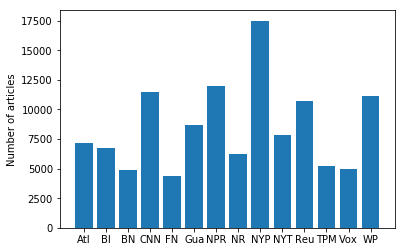

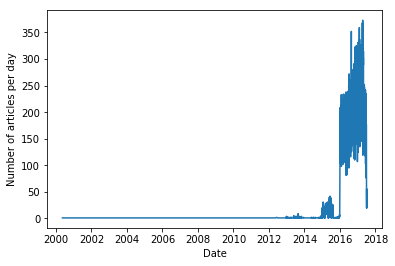

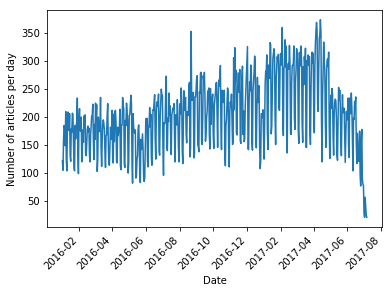

In [4]:
ticklabels=[]
for paper in (newsarts.groupby('publication').count().index):
    paperwords = paper.split(' ')
    if len(paperwords) > 1:
        # use intials to identify the paper
        pprinit = ''
        for word in paperwords:
            pprinit += word[0]
        ticklabels.append(pprinit)
    else:
        # use only first 3 words
        ticklabels.append(paperwords[0][0:3])
    
plt.bar(np.arange(len(newsarts.groupby('publication').count().index)), newsarts.groupby('publication').count()['title'].tolist(), 
        tick_label = ticklabels)
plt.ylabel('Number of articles')
plt.show()

sns.lineplot(data=newsarts.groupby('date').count()['title'])
plt.ylabel('Number of articles per day')
plt.xlabel('Date')
plt.show()


sns.lineplot(data=newsarts[newsarts['date']>'20160101'].groupby('date').count()['title'])
plt.ylabel('Number of articles per day')
plt.xticks(rotation = 45, ha="right")
plt.xlabel('Date')
plt.show()

In [5]:
newssept = pd.DataFrame()
for newsgroup in (newsarts.groupby('publication').count().index):
    tempdf = newsarts[newsarts['publication']==newsgroup]
    newssept[newsgroup]=tempdf.groupby('date').count()['title']
    
    
newssept = newssept.fillna(0)
newssept.head()

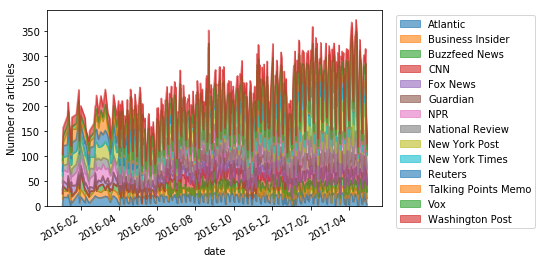

In [6]:
newssept.loc['20160101':'20170601'].plot.area(alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(1.25,1))
plt.ylabel('Number of articles')
plt.show()

In [7]:
newsarts['content']=newsarts['content'].replace('\n', ' ')
newsarts['content']=newsarts['content'].apply(lambda x: re.sub('[^0-9a-zA-Z]+', ' ',x))
newsarts.head()

Now, this is too many to run topic modelling on my local machine. I want to downsample to ca 25k articles in the range January 2016 to June 2017.

In [8]:
newsarts = newsarts.dropna()
newsarts=newsarts[newsarts['date']>='20160101']
newsarts=newsarts[newsarts['date']<='20170601']
newsarts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107211 entries, 0 to 142569
Data columns (total 4 columns):
title          107211 non-null object
publication    107211 non-null object
date           107211 non-null datetime64[ns]
content        107211 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.1+ MB


In [9]:
newsarts = newsarts.reset_index()

In [10]:
selectedarts = newsarts.iloc[np.random.choice(107211,10000)]
selectedarts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 23045 to 39194
Data columns (total 5 columns):
index          10000 non-null int64
title          10000 non-null object
publication    10000 non-null object
date           10000 non-null datetime64[ns]
content        10000 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 468.8+ KB


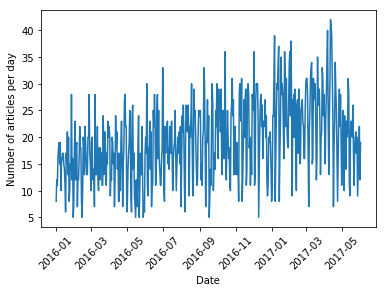

In [11]:
sns.lineplot(data=selectedarts.groupby('date').count()['title'])
plt.ylabel('Number of articles per day')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

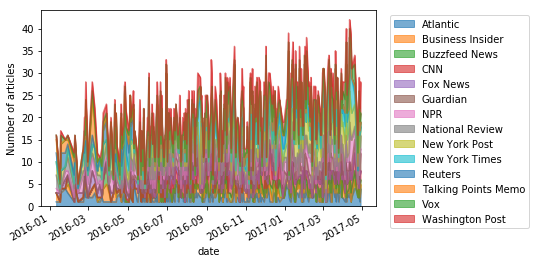

In [12]:
newssept = pd.DataFrame()
for newsgroup in (selectedarts.groupby('publication').count().index):
    tempdf = selectedarts[selectedarts['publication']==newsgroup]
    newssept[newsgroup]=tempdf.groupby('date').count()['title']
    
    
newssept = newssept.fillna(0)
newssept.plot.area(alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(1.25,1))
plt.ylabel('Number of articles')
plt.show()

The distribution looks similar to the previous one in number of articles per day and per newsgroup. We will perform topic modelling on this selection. I have to save it to upload it again saving memory...

In [13]:
selectedarts.to_csv('Selectedarticles.csv')
newsarts.to_csv('Allarticles.csv')